#  CIS 590K Deep Learning Assignment 3
## Recommendation System



**Author: Nithesh Veerappa**

**Student ID: 01883074**

**Date: 02/19/2023**

## Importing essential libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

from zipfile import ZipFile
from urllib.request import urlretrieve

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

## Model1: Explicit Recommendation System For Classifying Movie Ratings

### Downloading and extracting the dataset

In [2]:

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.split('/')[-1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [3]:
# Lodaing Raw ratings from "u.data" file
raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])

In [4]:
# Loading only the first 4 columns in "u.item" file as meta data
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', encoding='latin-1',
                    names=m_cols, usecols=range(5))

# Function that extracts release year from the above items table
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    return 1920 # Missing value marker

# extracting release year and creating new column in item df
items['release_year'] = items['release_date'].map(extract_year)
indexed_items = items.set_index('item_id')

#To visualize the distribution of the release year in the dataset
#items.hist('release_year', bins = 50)

#merging two extracted table (items and raw ratings)
all_ratings = pd.merge(items, raw_ratings)

In [5]:
#Data preprocessing
min_user_id = all_ratings['user_id'].min()
max_user_id = all_ratings['user_id'].max()

min_item_id = all_ratings['item_id'].min()
max_item_id = all_ratings['item_id'].max()

print('user_id range = ({},{})'.format(min_user_id, max_user_id))
print('item_id range = ({},{})'.format(min_item_id, max_item_id))
#all_ratings['rating'].describe()

#Engineering popularity feature and merging with all_ratings df
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
all_ratings = pd.merge(popularity, all_ratings)

user_id range = (1,943)
item_id range = (1,1682)


In [6]:
# Data split for training and testing
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating']) - 1

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating']) - 1

### Creating a deep neural model architecture for classification problem

In [7]:
class DeepClassificationRecSys(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_user_id + 1,
            input_length=1,
            name='user_embedding'
        )
        self.item_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_item_id + 1,
            input_length=1,
            name='item_embedding'
        )

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        ## Possible Error 1: Dropout is too high, preventing any training
        self.dropout = Dropout(0.5)
        self.dense1 = Dense(64, activation="relu")
        #self.dense2 = Dense(32, activation="relu")
        self.dense3 = Dense(5, activation = "softmax")

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        #y = self.dense2(y)
        y = self.dense3(y)
        return y


model = DeepClassificationRecSys(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### Training the deep neural network model with training dataset

In [8]:

history = model.fit([user_id_train, item_id_train], rating_train, batch_size=64, epochs=10, validation_split=0.1,shuffle=True)

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.3664 - accuracy: 0.3891 - val_loss: 1.2673 - val_accuracy: 0.4406
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.2737 - accuracy: 0.4357 - val_loss: 1.2524 - val_accuracy: 0.4536
Epoch 3/10
1125/1125 [==============================] - 5s 4ms/step - loss: 1.2505 - accuracy: 0.4472 - val_loss: 1.2505 - val_accuracy: 0.4479
Epoch 4/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.2367 - accuracy: 0.4534 - val_loss: 1.2424 - val_accuracy: 0.4527
Epoch 5/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2280 - accuracy: 0.4563 - val_loss: 1.2434 - val_accuracy: 0.4505
Epoch 6/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.2192 - accuracy: 0.4585 - val_loss: 1.2446 - val_accuracy: 0.4470
Epoch 7/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.2130 - accuracy: 0.4630 - val_loss: 1.2432 - val_accuracy:

### Testing the model with Test data

In [9]:
test_preds = model.predict([user_id_test, item_id_test])
train_preds = model.predict([user_id_train, item_id_train])

2500/2500 [==============================] - 3s 1ms/step


### Plotting the training and validation losses and Calculating MSE and MAE

Final train MSE: 1.016
Final train MAE: 0.650
Final test MSE: 1.127
Final test MAE: 0.717


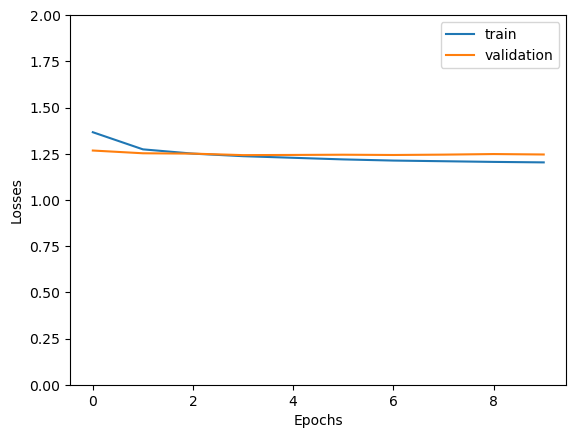

In [10]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

print("Final train MSE: %0.3f" % mean_squared_error(np.argmax(train_preds, axis = 1), rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(np.argmax(train_preds, axis = 1), rating_train))

print("Final test MSE: %0.3f" % mean_squared_error(np.argmax(test_preds, axis = 1), rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(np.argmax(test_preds, axis = 1), rating_test))

## Model 2: Implicit Recommendation System For Classifying Movie Ratings

### Downloading and extracting the dataset

In [11]:
# Lodaing Raw ratings from "u.data" file
data_train = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.base'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
data_test = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.test'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])

In [12]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items['release_year'] = items['release_date'].map(extract_year)

data_train = pd.merge(data_train, items)
data_test = pd.merge(data_test, items)

In [13]:
max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())

n_users = max_user_id + 1
n_items = max_item_id + 1

print('n_users=%d, n_items=%d' % (n_users, n_items))

pos_data_train = data_train.query("rating >= 4")
pos_data_test = data_test.query("rating >= 4")

n_users=944, n_items=1683


### Creating helper fucntions for identity loss, margin loss and Average ROC-AUC calculations

In [14]:
def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)

def sample_triplets(pos_data, max_item_id, random_seed=0):
    """Sample negatives at random"""
    rng = np.random.RandomState(random_seed)
    user_ids = pos_data['user_id'].values
    pos_item_ids = pos_data['item_id'].values

    neg_item_ids = rng.randint(low=1, high=max_item_id + 1,
                               size=len(user_ids))

    return [user_ids, pos_item_ids, neg_item_ids]


class MarginLoss(layers.Layer):

    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        print(diff)
        return tf.maximum(diff + self.margin, 0.)
    

def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(),
                      data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(),
                      data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(
            all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise.
        expected = np.in1d(
            items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(
                [repeated_user_id, items_to_rank], batch_size=4096, verbose = 0)
        
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

### Creating a generalized class for Multi-Layer Perceptron

In [15]:
class MultiLayerPerceptron(layers.Layer):
    def __init__(self, n_hidden=1, hidden_size=64, dropout=0., l2_reg=None):
        super().__init__()
        self.layers = [Dropout(dropout)]
        for i in range(n_hidden):
            self.layers.append(Dense(hidden_size, activation="relu", kernel_regularizer=l2_reg))
            self.layers.append(Dropout(dropout))
        self.layers.append(Dense(1, activation="relu", kernel_regularizer=l2_reg))
        
    def call(self, x, training=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

### Creating a deep neural network architecture for Deep Triplet Model

In [16]:
class DeepTripletModel(Model):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=1.,  n_hidden=1, 
                hidden_size=64, dropout=0, l2_reg=None):
        super().__init__()
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        self.user_layer = Embedding(n_users, user_dim,
                                    input_length=1,
                                    input_shape=(1,),  
                                    name='user_embedding',
                                    embeddings_regularizer=l2_reg)
        self.item_layer = Embedding(n_items,
                                    item_dim,
                                    input_length=1,
                                    name="item_embedding",
                                    embeddings_regularizer=l2_reg)
        self.flatten = Flatten()
        self.concat = Concatenate()
        self.mlp = MultiLayerPerceptron(n_hidden, hidden_size, dropout, l2_reg)
        self.margin_loss = MarginLoss(margin)
        

    def call(self, inputs, training=False):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        neg_item_input = inputs[2]
        
        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)
        
        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
        
        neg_item_embedding = self.item_layer(neg_item_input)
        neg_item_embedding = self.flatten(neg_item_embedding)
        
        # Similarity computation between embeddings
        pos_embeddings_pair = self.concat([user_embedding, pos_item_embedding])
        neg_embeddings_pair = self.concat([user_embedding, neg_item_embedding])
        
        pos_similarity = self.mlp(pos_embeddings_pair)
        neg_similarity = self.mlp(neg_embeddings_pair)
        
        return self.margin_loss([pos_similarity, neg_similarity])

### Creating a deep neural network architecture for Deep Match Model

In [17]:
class DeepMatchModel(Model):
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__(name="MatchModel")
        self.user_layer = user_layer
        self.item_layer = item_layer
        self.mlp = mlp
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        
    def call(self, inputs):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        
        user_embedding = self.flatten(self.user_layer(user_input))
        pos_item_embedding = self.flatten(self.item_layer(pos_item_input))
        
        pos_embeddings_pair = self.concat([user_embedding, pos_item_embedding])
        pos_similarity = self.mlp(pos_embeddings_pair)
        
        return pos_similarity

### Compiling the triplet and match models

In [18]:
hyper_parameters = dict(
    user_dim=32,
    item_dim=64,
    n_hidden=1,
    hidden_size=128,
    dropout=0.1,
    l2_reg=0)

deep_triplet_model = DeepTripletModel(n_users, n_items,
                                      **hyper_parameters)
deep_match_model = DeepMatchModel(deep_triplet_model.user_layer,
                                  deep_triplet_model.item_layer,
                                  deep_triplet_model.mlp)
deep_triplet_model.compile(loss=identity_loss, optimizer='adam')
fake_y = np.ones_like(pos_data_train['user_id'])

### Calculating the ROC_AUC of the deep model before training

In [19]:
test_AUC = average_roc_auc(deep_match_model, pos_data_train, pos_data_test)
print('Test_AUC Before Trainig: {}'.format(test_AUC))

Test_AUC Before Trainig: 0.49630985464205535


### Training the Deep Triplet Model with training dataset

In [20]:
#Model training: 
n_epochs = 20
for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(pos_data_train, max_item_id,
                                     random_seed=i)
    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                           batch_size=64, epochs=1)
    deep_match_model = DeepMatchModel(deep_triplet_model.user_layer,
                                  deep_triplet_model.item_layer,
                                  deep_triplet_model.mlp)

Tensor("deep_triplet_model/margin_loss/sub:0", shape=(None, 1), dtype=float32)
Tensor("deep_triplet_model/margin_loss/sub:0", shape=(None, 1), dtype=float32)
780/780 [==============================] - 3s 3ms/step - loss: 0.2576


### Calculating the ROC_AUC of the deep model after training

In [21]:
# Monitor the convergence of the model
test_auc = average_roc_auc(deep_match_model, pos_data_train, pos_data_test)
print("Epoch %d/%d: test ROC AUC: %0.4f"
      % (i + 1, n_epochs, test_auc))

Epoch 20/20: test ROC AUC: 0.9188


## End of Document